In [ ]:
import pandas as pd
import numpy as np
import requests as r
import json as j
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from datetime import date, time, datetime, timedelta
from google.colab import files

Names of the locations, their logtitudes and latitues are defined. The current location coordinations that are being used are taken from the cities of Nürnberg, Ingolstadt, Regensburg, Munich, and Ausburg. 

In [ ]:
location_data = dict()
location_data['names'] = ['Nürnberg', 'Ingolstadt', 'Regensburg', 'Munich', 'Ausburg']
location_data['x_coord'] = [11.126702,11.459927,12.068349,11.641047,10.952331]
location_data['y_coord'] = [49.434279,48.782418,48.999987,48.250762,48.400403]
busy_hours = [8,9,15,16]
#Dictionary that holds all info regarding the Gaussian distribution of 
#time multilpliers
multiplier_data = dict()
multiplier_data['busy'] = dict()
multiplier_data['busy']['mean'] = 1.25
multiplier_data['busy']['sd'] = 0.2
multiplier_data['normal'] = dict()
multiplier_data['normal']['mean'] = 1
multiplier_data['normal']['sd'] = 0.1
#Dictionary that holds information regarding date and time intervals
day_info = dict()
day_info['number_of_days']  = 60
day_info['day_start'] = 7
day_info['day_end'] = 18
day_info['interval_per_hour'] = 12


Function to combine all location data into one list object

In [ ]:
def PrepareLocationData(location_info):
  names = location_info['names']
  x_coord = location_info['x_coord']
  y_coord = location_info['y_coord']
  locations = list()
  for index, value in enumerate(names):
    location = dict()
    location['name'] = value
    location['x'] = x_coord[index]
    location['y'] = y_coord[index]
    locations.append(location)
  return locations

In [ ]:
test = PrepareLocationData(location_data)

In [ ]:
print(test)

[{'name': 'Nürnberg', 'x': 11.126702, 'y': 49.434279}, {'name': 'Ingolstadt', 'x': 11.459927, 'y': 48.782418}, {'name': 'Regensburg', 'x': 12.068349, 'y': 48.999987}, {'name': 'Munich', 'x': 11.641047, 'y': 48.250762}, {'name': 'Ausburg', 'x': 10.952331, 'y': 48.400403}]


In [ ]:
def GetTravelTime(location_master):
  coordinate_string = ''
  waypoints = list()
  for i in location_master:
    waypoints.append((i['x'],i['y']))
  waypoint_string = ';'.join(map(lambda pt: '{},{}'.format(*pt), waypoints))
  osrm_host = 'http://router.project-osrm.org'
  osrm_request = '/table/v1/driving/'
  travel_matrix = r.get('{}{}{}'.format(osrm_host,osrm_request,waypoint_string))
  travel_json = j.loads(travel_matrix.text)
  travel_matrix = travel_json['durations']
  return travel_matrix

In [ ]:
payload = GetTravelTime(test)

In [ ]:
#def get_distances(location_master):
#  distance_matrix = list()
#  for l in location_master:
#    coord_1 = [l['x'],l['y']]
#    distance_row = list()
#    for i in location_master:
#      coord_2 = [i['x'],i['y']]
#      distance = distance.euclidean(coord_1,coord_2)
      
      

In [ ]:
def CreateTimeMultiplier(day_data,busy_hours,multipliers):
  distribution_list = list()
  for i in range(day_data['day_start'],day_data['day_end']):
    for j in range(0,day_data['interval_per_hour']):
      if i in busy_hours:
        distribution_list.append(np.random.normal(multipliers['busy']['mean'], multipliers['busy']['sd']))
      else:
        distribution_list.append(np.random.normal(multipliers['normal']['mean'], multipliers['normal']['sd']))
  multiplier_smoothed = uniform_filter1d(distribution_list,6)
  return multiplier_smoothed



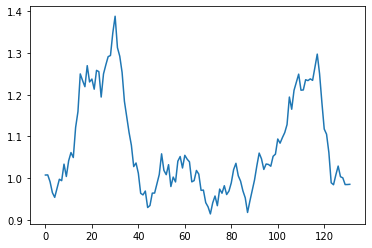

In [ ]:
plt.plot(CreateTimeMultiplier(day_info,busy_hours,multiplier_data))

location_names = [1,2,3,4,5]
location_x = [11.126702,11.459927,12.068349,11.641047,10.952331]
location_y = [49.434279,48.782418,48.999987,48.250762,48.400403]
busy_hours = [8,9,15,16]
#Dictionary that holds all info regarding the Gaussian distribution of 
#time multilpliers
multiplier_data = dict()
multiplier_data['busy'] = dict()
multiplier_data['busy']['mean'] = 1.25
multiplier_data['busy']['sd'] = 0.2
multiplier_data['normal'] = dict()
multiplier_data['normal']['mean'] = 1
multiplier_data['normal']['sd'] = 0.1
#Dictionary that holds information regarding date and time intervals
day_info = dict()
day_info['number_of_days']  = 60
day_info['day_start'] = 7
day_info['day_end'] = 18
day_info['interval_per_hour'] = 12

In [ ]:
def CreateDummyData(location_info,busy_hours,day_data,multipliers):
  date_base = datetime.today()
  date_list = [date_base - timedelta(days=x) for x in range(day_data['number_of_days'])]
  hour_list = list()
  hour_step = int(60/day_data['interval_per_hour'])
  for hour in range(day_data['day_start'],day_data['day_end']):
    for minute in range(0,60,hour_step):
      hour_list.append(time(hour=hour,minute=minute))
  locations = location_info['names']
  travel_time = GetTravelTime(PrepareLocationData(location_info))
  master_data = list()
  for date_value in date_list:
    for index_source, source in enumerate(locations):
      for index_destination, destination in enumerate(locations):
        if source != destination:
          time_multiplier = CreateTimeMultiplier(day_data,busy_hours,multipliers)
          original_travel_time = travel_time[index_source][index_destination]
          adjusted_travel_time = [multiplier * original_travel_time for multiplier in time_multiplier]
          for hour_index, hour in enumerate(hour_list):
            data_row = dict()
            data_row['date'] = date_value.strftime("%Y-%m-%d")
            data_row['hour'] = hour
            data_row['source'] = source
            data_row['destination'] = destination
            data_row['duration'] = adjusted_travel_time[hour_index]
            master_data.append(data_row)
  return master_data


In [ ]:
location_master = PrepareLocationData(location_data)
data = CreateDummyData(location_data,busy_hours,day_info,multiplier_data)

In [ ]:
data_pandas = pd.DataFrame(data)

In [ ]:
data_pandas

,date,hour,source,destination,duration
0,2022-02-22,07:00:00,Nürnberg,Ingolstadt,3143.148095
1,2022-02-22,07:05:00,Nürnberg,Ingolstadt,3098.957593
2,2022-02-22,07:10:00,Nürnberg,Ingolstadt,3067.347150
3,2022-02-22,07:15:00,Nürnberg,Ingolstadt,3127.657786
4,2022-02-22,07:20:00,Nürnberg,Ingolstadt,3118.600806
...,...,...,...,...,...
158395,2021-12-25,17:35:00,Ausburg,Munich,2320.107005
158396,2021-12-25,17:40:00,Ausburg,Munich,2295.627799
158397,2021-12-25,17:45:00,Ausburg,Munich,2217.414351
158398,2021-12-25,17:50:00,Ausburg,Munich,2196.928242


In [ ]:
data_pandas.to_csv('dummy_traffic_data.csv', encoding = 'utf-8-sig',index=False) 
files.download('dummy_traffic_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>